In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn 
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [123]:
import io
import pickle
import tarfile
from models.utils import fetch

def load_cifar():
  print("loading data")
  tt = tarfile.open(fileobj=io.BytesIO(fetch("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")), mode="r:gz")
  for i in range(5):
    db = pickle.load(tt.extractfile(f"cifar-10-batches-py/data_batch_{i+1}"), encoding="bytes")
    if i == 0:
      X_train = db[b'data'].reshape((-1, 3, 32, 32))
      Y_train = np.array(db[b'labels'])
    else:
      X_train = np.concatenate((X_train, db[b'data'].reshape((-1, 3, 32, 32))))
      Y_train = np.concatenate((Y_train, np.array(db[b'labels'])))
  db = pickle.load(tt.extractfile("cifar-10-batches-py/test_batch"), encoding="bytes")
  X_test = db[b'data'].reshape((-1, 3, 32, 32)) 
  Y_test = np.array(db[b'labels']) 
  print("loaded data")
  return X_train, Y_train, X_test, Y_test

loading data
loaded data
6


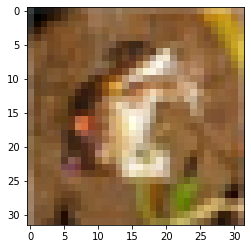

In [124]:
X_train, Y_train, X_test, Y_test = load_cifar()
imshow(X_train[0].T)
print(Y_train[0]) # apparently a frog

In [128]:
from models.efficientnet import EfficientNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size= 128
model = EfficientNet(number=0, classes=10, has_se=True).to(device)
model.load_from_pretrained()
loss_fn = nn.CrossEntropyLoss()
import apex
optimizer = apex.optimizers.FusedAdam(model.parameters())
#optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
for i in (t := trange(2000)):
  samp = np.random.randint(0, X_train.shape[0], size=batch_size)
  X = torch.tensor(X_train[samp]).float().to(device)
  Y = torch.tensor(Y_train[samp]).long().to(device)
  optimizer.zero_grad()
  out = model(X)
  accuracy = (out.argmax(dim=1) == Y).float().mean()
  loss = loss_fn(out, Y)
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  accuracies.append(accuracy.item())
  t.set_description(f"loss {loss:.4f} accuracy {accuracy:.4f}")

loss 0.3861 accuracy 0.8906: 100%|██████████| 2000/2000 [02:57<00:00, 11.28it/s]


2000


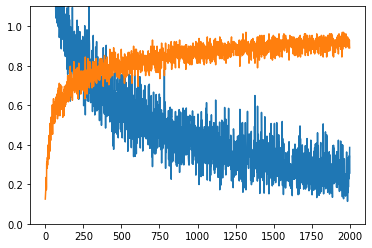

In [129]:
ylim(0, 1.1)
plot(losses)
plot(accuracies)

In [130]:
test_accuracies = []
for i in range(50):
  samp = np.random.randint(0, X_test.shape[0], size=256)
  X = torch.tensor(X_test[samp]).float().to(device)
  Y = torch.tensor(Y_test[samp]).float().to(device)
  accuracy = (model(X).argmax(dim=1) == Y).float().mean()
  test_accuracies.append(accuracy.cpu().detach().numpy())
np.array(test_accuracies).mean()

0.8055469